In [1]:
from datetime import datetime, timedelta
from collections import defaultdict

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [4]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("decision_tree_tuning")

2024/11/15 12:25:24 INFO mlflow.tracking.fluent: Experiment with name 'decision_tree_tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/lld-lead-scoring/analytics/mlruns/2', creation_time=1731673524680, experiment_id='2', last_update_time=1731673524680, lifecycle_stage='active', name='decision_tree_tuning', tags={}>

In [5]:
df_users = pd.read_csv('../data/random-users.csv')
df_logs = pd.read_csv('../data/random-logs.csv')

In [6]:
def preprocess_required_features(df):
    df = df.copy()
    
    def process_feature_string(feature_string):
        features = [f.strip() for f in feature_string.split(',')]
        return {f'required_feature_{feature}': 1 for feature in features}
    
    feature_dicts = df['required_features'].apply(process_feature_string)
    df = df.drop('required_features', axis=1)
    record_dicts = df.to_dict('records')
    
    for record, feature_dict in zip(record_dicts, feature_dicts):
        record.update(feature_dict)
    
    return record_dicts

In [7]:
def create_log_features(df_users, df_logs, cutoff_date):
    df_logs_filtered = df_logs[df_logs['timestamp'] < cutoff_date].copy()
    
    engagement_metrics = df_logs_filtered.groupby('user_id').agg({
        'timestamp': ['count', 'nunique'],  # Total actions and unique days
        'duration_seconds': ['sum', 'mean', 'std']  # Time spent metrics
    }).round(2)
    
    engagement_metrics.columns = [
        'total_actions',
        'active_days',
        'total_duration',
        'avg_duration',
        'std_duration'
    ]
    
    # Action category distribution
    category_counts = df_logs_filtered.groupby(['user_id', 'action_category']).size().unstack(
        fill_value=0
    ).add_prefix('category_')
    
    # Action type distribution (top 10 most common)
    top_actions = df_logs_filtered['action_type'].value_counts().nlargest(10).index
    action_counts = df_logs_filtered[df_logs_filtered['action_type'].isin(top_actions)]\
        .groupby(['user_id', 'action_type']).size().unstack(fill_value=0).add_prefix('action_')
    
    # Time-based features
    df_logs_filtered['hour'] = df_logs_filtered['timestamp'].dt.hour
    time_metrics = df_logs_filtered.groupby('user_id').agg({
        'hour': lambda x: len(x[x.between(9, 17)]) / len(x)  # Fraction of activity during business hours
    }).round(2)
    time_metrics.columns = ['business_hours_ratio']
    
    # Activity patterns
    df_logs_filtered['days_since_signup'] = (
        df_logs_filtered['timestamp'] - 
        df_logs_filtered['user_id'].map(df_users.set_index('user_id')['signup_date'])
    ).dt.days
    
    recency_metrics = df_logs_filtered.groupby('user_id').agg({
        'days_since_signup': ['min', 'max']
    }).round(2)
    recency_metrics.columns = ['days_to_first_action', 'days_to_last_action']
    
    # Advanced engagement metrics
    df_logs_filtered['prev_timestamp'] = df_logs_filtered.groupby('user_id')['timestamp'].shift(1)
    df_logs_filtered['time_between_actions'] = (
        df_logs_filtered['timestamp'] - df_logs_filtered['prev_timestamp']
    ).dt.total_seconds() / 3600  # Convert to hours
    
    engagement_patterns = df_logs_filtered.groupby('user_id').agg({
        'time_between_actions': ['mean', 'std']
    }).round(2)
    engagement_patterns.columns = ['avg_hours_between_actions', 'std_hours_between_actions']
    
    # Feature importance indicators
    feature_exploration = df_logs_filtered[
        df_logs_filtered['action_type'] == 'view_features'
    ].groupby('user_id').size().to_frame('feature_views')
    
    # Combine all features
    log_features = pd.concat([
        engagement_metrics,
        category_counts,
        action_counts,
        time_metrics,
        recency_metrics,
        engagement_patterns,
        feature_exploration
    ], axis=1).reset_index()
    
    # Fill NaN values with 0 for new users or users with missing metrics
    log_features = log_features.fillna(0)
    
    return log_features


def prepare_lead_scoring_data(df_users, df_logs, train_end_date, val_end_date):
    df_users = df_users.copy()
    df_logs = df_logs.copy()
    
    df_users['signup_date'] = pd.to_datetime(df_users['signup_date'])
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'])
    
    train_end_date = pd.to_datetime(train_end_date)
    val_end_date = pd.to_datetime(val_end_date)
    
    train_mask = df_users['signup_date'] < train_end_date
    val_mask = (df_users['signup_date'] >= train_end_date) & (df_users['signup_date'] < val_end_date)
    test_mask = df_users['signup_date'] >= val_end_date
    
    df_train = df_users[train_mask].copy()
    df_val = df_users[val_mask].copy()
    df_test = df_users[test_mask].copy()
    
    train_features = create_log_features(df_users, df_logs, train_end_date)
    val_features = create_log_features(df_users, df_logs, val_end_date)
    test_features = create_log_features(df_users, df_logs, df_logs['timestamp'].max())

    df_train = df_train.merge(train_features, on='user_id', how='left')
    df_val = df_val.merge(val_features, on='user_id', how='left')
    df_test = df_test.merge(test_features, on='user_id', how='left')

    return df_train, df_val, df_test

In [8]:
df_train, df_val, df_test = prepare_lead_scoring_data(
    df_users,
    df_logs,
    train_end_date='2024-03-01',
    val_end_date='2024-03-15'
)

In [9]:
def prepare_features(df):
    df = df.copy()
    
    date_columns = ['signup_date', 'conversion_date']
    exclude_columns = ['user_id', 'converted'] + date_columns

    df = df.drop(columns=exclude_columns)
    df = df.fillna(0)
    feature_dict = preprocess_required_features(df)

    return feature_dict

train_dicts = prepare_features(df_train)
val_dicts = prepare_features(df_val)
test_dicts = prepare_features(df_test)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [30]:
pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier(
        max_depth=5,              # Prevent overfitting
        min_samples_leaf=50,      # Ensure stable leaf predictions
        class_weight='balanced',  # Handle class imbalance
        random_state=1
    )
)

pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict_proba(val_dicts)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
val_auc

np.float64(0.5609871196979791)

In [19]:


feature_names = pipeline[0].get_feature_names_out()
importances = pipeline[1].feature_importances_

print("Top 20 most important features:")
feature_importance = list(zip(feature_names, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)
for feature, importance in feature_importance[:20]:
    print(f"{feature}: {importance:.4f}")

Top 20 most important features:
avg_duration: 0.4039
avg_hours_between_actions: 0.2159
category_platform_exploration: 0.0951
action_invite_users: 0.0748
organization_type=Professional Training Provider: 0.0550
business_hours_ratio: 0.0523
primary_use_case=Skills Development: 0.0454
decision_timeframe=3-6 months: 0.0374
days_to_last_action: 0.0202
action_configure_dashboard: 0.0000
action_create_assignment: 0.0000
action_create_course: 0.0000
action_grade_submission: 0.0000
action_organize_content: 0.0000
action_publish_course: 0.0000
action_record_session: 0.0000
action_setup_integration: 0.0000
action_view_features: 0.0000
active_days: 0.0000
category_analytics: 0.0000


In [22]:
from sklearn.tree import plot_tree, export_text

In [24]:
tree = pipeline[1]

Text(0.5, 1.0, 'Decision Tree Visualization')

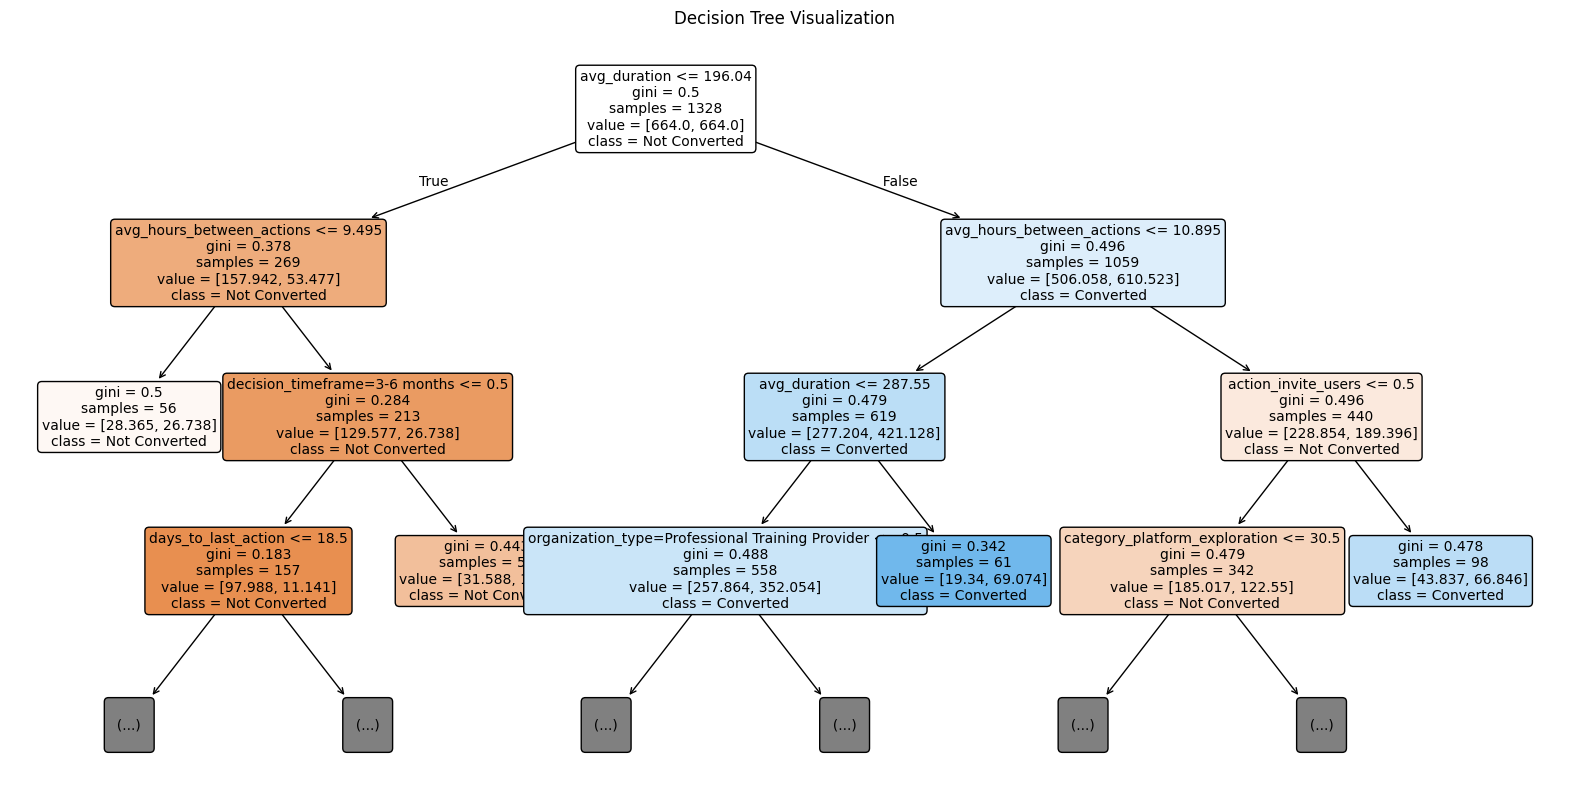

In [25]:
plt.figure(figsize=(20,10))
plot_tree(
    tree, 
    feature_names=feature_names,
    class_names=['Not Converted', 'Converted'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # Limit depth for visibility
)
plt.title("Decision Tree Visualization")

In [27]:
text = export_text(
    tree, 
    feature_names=feature_names, 
    show_weights=True,
    spacing=3
)

In [28]:
print(text)

|--- avg_duration <= 196.04
|   |--- avg_hours_between_actions <= 9.50
|   |   |--- weights: [28.37, 26.74] class: False
|   |--- avg_hours_between_actions >  9.50
|   |   |--- decision_timeframe=3-6 months <= 0.50
|   |   |   |--- days_to_last_action <= 18.50
|   |   |   |   |--- weights: [48.99, 11.14] class: False
|   |   |   |--- days_to_last_action >  18.50
|   |   |   |   |--- weights: [48.99, 0.00] class: False
|   |   |--- decision_timeframe=3-6 months >  0.50
|   |   |   |--- weights: [31.59, 15.60] class: False
|--- avg_duration >  196.04
|   |--- avg_hours_between_actions <= 10.89
|   |   |--- avg_duration <= 287.55
|   |   |   |--- organization_type=Professional Training Provider <= 0.50
|   |   |   |   |--- business_hours_ratio <= 0.47
|   |   |   |   |   |--- weights: [202.42, 271.84] class: True
|   |   |   |   |--- business_hours_ratio >  0.47
|   |   |   |   |   |--- weights: [16.76, 55.70] class: True
|   |   |   |--- organization_type=Professional Training Provider >

In [34]:
n_trials = 30
param_ranges = {
    'max_depth': range(3, 10),
    'min_samples_leaf': range(10, 100),
    'min_samples_split': range(10, 100)
}

# Track best model
best_auc = 0
best_params = None
best_model = None

# Simple random search
for trial in range(n_trials):
    print(f"Trial #{trial}")
    with mlflow.start_run():
        params = {
            'max_depth': np.random.choice(param_ranges['max_depth']),
            'min_samples_leaf': np.random.choice(param_ranges['min_samples_leaf']),
            'min_samples_split': np.random.choice(param_ranges['min_samples_split']),
            'class_weight': 'balanced',
            'random_state': 1
        }
        
        pipeline = make_pipeline(
            DictVectorizer(),
            DecisionTreeClassifier(**params)
        )
        pipeline.fit(train_dicts, y_train)
        
        train_pred = pipeline.predict_proba(train_dicts)[:, 1]
        val_pred = pipeline.predict_proba(val_dicts)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)

        mlflow.log_params(params)
        mlflow.log_metrics({
            'train_auc': train_auc,
            'val_auc': val_auc
        })

        mlflow.sklearn.log_model(pipeline, "model")
    
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params.copy()
            best_model = pipeline
            
        print(f"Trial {trial + 1}/{n_trials}:")
        print(f"Params: {params}")
        print(f"Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Best Val AUC so far: {best_auc:.4f}")
        print()

print("Best parameters:", best_params)
print("Best validation AUC:", best_auc)

Trial #0


2024/11/15 13:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-dolphin-488 at: http://localhost:5000/#/experiments/2/runs/402ad2eb87aa44bb8cb74fe97b953b71.
2024/11/15 13:03:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 1/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(25), 'min_samples_split': np.int64(62), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6616, Val AUC: 0.5748
Best Val AUC so far: 0.5748

Trial #1


2024/11/15 13:03:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-pig-209 at: http://localhost:5000/#/experiments/2/runs/7e2af5e836714c39a6a746e44d96fbc0.
2024/11/15 13:03:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 2/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(17), 'min_samples_split': np.int64(74), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6616, Val AUC: 0.5748
Best Val AUC so far: 0.5748

Trial #2


2024/11/15 13:03:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-sheep-121 at: http://localhost:5000/#/experiments/2/runs/344a47f651264679a7f542c2f0fe9785.
2024/11/15 13:03:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 3/30:
Params: {'max_depth': np.int64(9), 'min_samples_leaf': np.int64(71), 'min_samples_split': np.int64(20), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7145, Val AUC: 0.5336
Best Val AUC so far: 0.5748

Trial #3


2024/11/15 13:03:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-donkey-187 at: http://localhost:5000/#/experiments/2/runs/b00edce577454ab58809866480d53064.
2024/11/15 13:03:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 4/30:
Params: {'max_depth': np.int64(6), 'min_samples_leaf': np.int64(88), 'min_samples_split': np.int64(13), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7035, Val AUC: 0.5685
Best Val AUC so far: 0.5748

Trial #4


2024/11/15 13:03:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-sloth-833 at: http://localhost:5000/#/experiments/2/runs/c701393fa9f540a68dd37ebfba6264d4.
2024/11/15 13:03:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 5/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(24), 'min_samples_split': np.int64(70), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6879, Val AUC: 0.5756
Best Val AUC so far: 0.5756

Trial #5


2024/11/15 13:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-pug-189 at: http://localhost:5000/#/experiments/2/runs/40c9c785f3d34c0c988bd2bbad0a067b.
2024/11/15 13:03:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 6/30:
Params: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(47), 'min_samples_split': np.int64(37), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7275, Val AUC: 0.5484
Best Val AUC so far: 0.5756

Trial #6


2024/11/15 13:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-boar-530 at: http://localhost:5000/#/experiments/2/runs/3b6d07bb5a1d4411a3949001b74ca15e.
2024/11/15 13:03:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 7/30:
Params: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(18), 'min_samples_split': np.int64(19), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7605, Val AUC: 0.5695
Best Val AUC so far: 0.5756

Trial #7


2024/11/15 13:03:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-calf-603 at: http://localhost:5000/#/experiments/2/runs/7e0041810fd646bea16fffb0987869e1.
2024/11/15 13:03:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 8/30:
Params: {'max_depth': np.int64(6), 'min_samples_leaf': np.int64(28), 'min_samples_split': np.int64(17), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7289, Val AUC: 0.5727
Best Val AUC so far: 0.5756

Trial #8


2024/11/15 13:03:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-skunk-7 at: http://localhost:5000/#/experiments/2/runs/317da7fa53094e54bea5736dadae5cce.
2024/11/15 13:03:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 9/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(37), 'min_samples_split': np.int64(43), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6616, Val AUC: 0.5748
Best Val AUC so far: 0.5756

Trial #9


2024/11/15 13:03:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-squid-800 at: http://localhost:5000/#/experiments/2/runs/1f7d396847cc4ed19e397757bd211a61.
2024/11/15 13:03:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 10/30:
Params: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(43), 'min_samples_split': np.int64(65), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6990, Val AUC: 0.5648
Best Val AUC so far: 0.5756

Trial #10


2024/11/15 13:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-koi-128 at: http://localhost:5000/#/experiments/2/runs/5794902de44d4cb0b214b7938e9008a0.
2024/11/15 13:03:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 11/30:
Params: {'max_depth': np.int64(9), 'min_samples_leaf': np.int64(96), 'min_samples_split': np.int64(53), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7037, Val AUC: 0.5701
Best Val AUC so far: 0.5756

Trial #11


2024/11/15 13:03:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-flea-292 at: http://localhost:5000/#/experiments/2/runs/39fbaaf7a9fe46959c2cf1d86b702a5c.
2024/11/15 13:03:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 12/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(98), 'min_samples_split': np.int64(93), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6565, Val AUC: 0.5245
Best Val AUC so far: 0.5756

Trial #12


2024/11/15 13:03:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-mole-655 at: http://localhost:5000/#/experiments/2/runs/9064273a325b4a3e800eb3b8936efe94.
2024/11/15 13:03:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 13/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(46), 'min_samples_split': np.int64(63), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6607, Val AUC: 0.5794
Best Val AUC so far: 0.5794

Trial #13


2024/11/15 13:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-ray-566 at: http://localhost:5000/#/experiments/2/runs/77b65ddfbb4f4c37b982831a3dfe3cb9.
2024/11/15 13:03:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 14/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(84), 'min_samples_split': np.int64(91), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6776, Val AUC: 0.5394
Best Val AUC so far: 0.5794

Trial #14


2024/11/15 13:03:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:03:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-foal-550 at: http://localhost:5000/#/experiments/2/runs/421650ccc8d64e95935e6267bba2781c.
2024/11/15 13:03:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 15/30:
Params: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(62), 'min_samples_split': np.int64(94), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6909, Val AUC: 0.5612
Best Val AUC so far: 0.5794

Trial #15


2024/11/15 13:04:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-goat-399 at: http://localhost:5000/#/experiments/2/runs/c7770fbdbfc54fa9875dbc36f89428fe.
2024/11/15 13:04:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 16/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(92), 'min_samples_split': np.int64(89), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6565, Val AUC: 0.5245
Best Val AUC so far: 0.5794

Trial #16


2024/11/15 13:04:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-goat-15 at: http://localhost:5000/#/experiments/2/runs/4c6776060db24c879cc1b92f68543b73.
2024/11/15 13:04:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 17/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(83), 'min_samples_split': np.int64(53), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6776, Val AUC: 0.5394
Best Val AUC so far: 0.5794

Trial #17


2024/11/15 13:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-panda-477 at: http://localhost:5000/#/experiments/2/runs/b45a51a43ab748bda12ee89fa6a0691c.
2024/11/15 13:04:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 18/30:
Params: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(31), 'min_samples_split': np.int64(69), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7030, Val AUC: 0.5686
Best Val AUC so far: 0.5794

Trial #18


2024/11/15 13:04:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-vole-472 at: http://localhost:5000/#/experiments/2/runs/6e63b8cb4b94476e96818d40d85afdad.
2024/11/15 13:04:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 19/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(32), 'min_samples_split': np.int64(52), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6873, Val AUC: 0.5756
Best Val AUC so far: 0.5794

Trial #19


2024/11/15 13:04:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-shrike-337 at: http://localhost:5000/#/experiments/2/runs/f22e5c440a2d436d8aad08900a023fd4.
2024/11/15 13:04:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 20/30:
Params: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(80), 'min_samples_split': np.int64(60), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7059, Val AUC: 0.5857
Best Val AUC so far: 0.5857

Trial #20


2024/11/15 13:04:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-zebra-926 at: http://localhost:5000/#/experiments/2/runs/a18e1829ab1648b4b68b8b7176c32360.
2024/11/15 13:04:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 21/30:
Params: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(27), 'min_samples_split': np.int64(75), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7281, Val AUC: 0.5839
Best Val AUC so far: 0.5857

Trial #21


2024/11/15 13:04:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-roo-956 at: http://localhost:5000/#/experiments/2/runs/d2ec9ca3fd4e42ce8759d96d7cb1be63.
2024/11/15 13:04:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 22/30:
Params: {'max_depth': np.int64(8), 'min_samples_leaf': np.int64(74), 'min_samples_split': np.int64(42), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7141, Val AUC: 0.5320
Best Val AUC so far: 0.5857

Trial #22


2024/11/15 13:04:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-sow-141 at: http://localhost:5000/#/experiments/2/runs/17b6c7c03d7a48e884175caeac250618.
2024/11/15 13:04:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 23/30:
Params: {'max_depth': np.int64(8), 'min_samples_leaf': np.int64(61), 'min_samples_split': np.int64(50), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7179, Val AUC: 0.5444
Best Val AUC so far: 0.5857

Trial #23


2024/11/15 13:04:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-eel-340 at: http://localhost:5000/#/experiments/2/runs/189078a9100e4efeb04820e6042e3daa.
2024/11/15 13:04:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 24/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(42), 'min_samples_split': np.int64(44), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6852, Val AUC: 0.5809
Best Val AUC so far: 0.5857

Trial #24


2024/11/15 13:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-sheep-861 at: http://localhost:5000/#/experiments/2/runs/e2efd56aa0134e4696386dc2d5499aaf.
2024/11/15 13:04:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 25/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(19), 'min_samples_split': np.int64(58), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6888, Val AUC: 0.5758
Best Val AUC so far: 0.5857

Trial #25


2024/11/15 13:04:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-flea-813 at: http://localhost:5000/#/experiments/2/runs/50e9f88475fe4ff69ed9220f4965d43c.
2024/11/15 13:04:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 26/30:
Params: {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(65), 'min_samples_split': np.int64(75), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6812, Val AUC: 0.5149
Best Val AUC so far: 0.5857

Trial #26


2024/11/15 13:04:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-shrike-498 at: http://localhost:5000/#/experiments/2/runs/f694d190b67b4dfa8c5d2d4000d4020e.
2024/11/15 13:04:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 27/30:
Params: {'max_depth': np.int64(6), 'min_samples_leaf': np.int64(92), 'min_samples_split': np.int64(62), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7035, Val AUC: 0.5685
Best Val AUC so far: 0.5857

Trial #27


2024/11/15 13:04:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-carp-894 at: http://localhost:5000/#/experiments/2/runs/c7fff2f9d19a49d3af773beb054c8bf1.
2024/11/15 13:04:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 28/30:
Params: {'max_depth': np.int64(9), 'min_samples_leaf': np.int64(40), 'min_samples_split': np.int64(64), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7463, Val AUC: 0.5387
Best Val AUC so far: 0.5857

Trial #28


2024/11/15 13:04:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-lamb-864 at: http://localhost:5000/#/experiments/2/runs/7cec517377cc489e9fa12c03cc164985.
2024/11/15 13:04:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 29/30:
Params: {'max_depth': np.int64(3), 'min_samples_leaf': np.int64(65), 'min_samples_split': np.int64(11), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.6607, Val AUC: 0.5280
Best Val AUC so far: 0.5857

Trial #29


2024/11/15 13:04:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:04:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-mouse-458 at: http://localhost:5000/#/experiments/2/runs/88eaae458b5e47f9aac7bc0fc3ddc29d.
2024/11/15 13:04:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


Trial 30/30:
Params: {'max_depth': np.int64(7), 'min_samples_leaf': np.int64(73), 'min_samples_split': np.int64(86), 'class_weight': 'balanced', 'random_state': 1}
Train AUC: 0.7142, Val AUC: 0.5336
Best Val AUC so far: 0.5857

Best parameters: {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(80), 'min_samples_split': np.int64(60), 'class_weight': 'balanced', 'random_state': 1}
Best validation AUC: 0.5857483899622474


In [32]:
best_model

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=np.int64(9),
                                        min_samples_leaf=np.int64(78),
                                        min_samples_split=np.int64(13),
                                        random_state=1))])

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier(
        n_estimators=100,        # Good balance between performance and training time
        max_depth=10,           # Deep enough to learn patterns, not too deep to overfit
        min_samples_leaf=20,    # Ensure stable predictions
        min_samples_split=20,   # Control tree splits
        class_weight='balanced', # Handle class imbalance
        n_jobs=-1,              # Use all CPU cores
        random_state=1
    )
)

In [37]:
pipeline.fit(train_dicts, y_train)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=20,
                                        min_samples_split=20, n_jobs=-1,
                                        random_state=1))])

In [38]:
train_pred = pipeline.predict_proba(train_dicts)[:, 1]
val_pred = pipeline.predict_proba(val_dicts)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)

print(f"Train AUC: {train_auc:.4f}")
print(f"Val AUC: {val_auc:.4f}")

Train AUC: 0.8489
Val AUC: 0.6281


In [39]:
mlflow.set_experiment("random_forest_tuning")

2024/11/15 13:07:44 INFO mlflow.tracking.fluent: Experiment with name 'random_forest_tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/lld-lead-scoring/analytics/mlruns/3', creation_time=1731676064529, experiment_id='3', last_update_time=1731676064529, lifecycle_stage='active', name='random_forest_tuning', tags={}>

In [40]:
# Parameter ranges
n_trials = 30
param_ranges = {
    'n_estimators': range(50, 200),
    'max_depth': range(5, 20),
    'min_samples_leaf': range(10, 100),
    'min_samples_split': range(10, 100)
}

# Track best model
best_auc = 0
best_params = None
best_model = None

# Simple random search
for trial in range(n_trials):
    with mlflow.start_run():
        # Sample random parameters
        params = {
            'n_estimators': np.random.choice(param_ranges['n_estimators']),
            'max_depth': np.random.choice(param_ranges['max_depth']),
            'min_samples_leaf': np.random.choice(param_ranges['min_samples_leaf']),
            'min_samples_split': np.random.choice(param_ranges['min_samples_split']),
            'class_weight': 'balanced',
            'n_jobs': -1,
            'random_state': 1
        }
        
        # Create and train pipeline
        pipeline = make_pipeline(
            DictVectorizer(),
            RandomForestClassifier(**params)
        )
        pipeline.fit(train_dicts, y_train)
        
        # Evaluate
        train_pred = pipeline.predict_proba(train_dicts)[:, 1]
        val_pred = pipeline.predict_proba(val_dicts)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        # Log with mlflow
        mlflow.log_params(params)
        mlflow.log_metrics({
            'train_auc': train_auc,
            'val_auc': val_auc
        })
        mlflow.sklearn.log_model(pipeline, "model")

        # Update best model
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params.copy()
            best_model = pipeline
            
        print(f"Trial {trial + 1}/{n_trials}:")
        print(f"Params: {params}")
        print(f"Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Best Val AUC so far: {best_auc:.4f}")
        print()

print("Best parameters:", best_params)
print("Best validation AUC:", best_auc)

2024/11/15 13:08:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trial 1/30:
Params: {'n_estimators': np.int64(101), 'max_depth': np.int64(19), 'min_samples_leaf': np.int64(65), 'min_samples_split': np.int64(45), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7175, Val AUC: 0.6107
Best Val AUC so far: 0.6107



2024/11/15 13:08:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-cow-198 at: http://localhost:5000/#/experiments/3/runs/fdf4d10880cc4f56b4dea5a70675eef8.
2024/11/15 13:08:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.
2024/11/15 13:08:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:08:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-gnat-530 at: http://localhost:5000/#/experiments/3/runs/9f3aae746c6248b8b463c1e86648fdc3.
2024/11/15 13:08:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 2/30:
Params: {'n_estimators': np.int64(153), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(29), 'min_samples_split': np.int64(75), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7836, Val AUC: 0.6052
Best Val AUC so far: 0.6107



2024/11/15 13:08:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:08:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-sow-205 at: http://localhost:5000/#/experiments/3/runs/80f23ef8c510418c8d23498c1b430bc6.
2024/11/15 13:08:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 3/30:
Params: {'n_estimators': np.int64(185), 'max_depth': np.int64(9), 'min_samples_leaf': np.int64(41), 'min_samples_split': np.int64(44), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7606, Val AUC: 0.6055
Best Val AUC so far: 0.6107



2024/11/15 13:09:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-bee-997 at: http://localhost:5000/#/experiments/3/runs/e0423eea5910473b9320046312af381d.
2024/11/15 13:09:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 4/30:
Params: {'n_estimators': np.int64(176), 'max_depth': np.int64(5), 'min_samples_leaf': np.int64(16), 'min_samples_split': np.int64(97), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7639, Val AUC: 0.6029
Best Val AUC so far: 0.6107



2024/11/15 13:09:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-lynx-153 at: http://localhost:5000/#/experiments/3/runs/2516315b92054091b102e325a0ac32cf.
2024/11/15 13:09:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 5/30:
Params: {'n_estimators': np.int64(181), 'max_depth': np.int64(12), 'min_samples_leaf': np.int64(92), 'min_samples_split': np.int64(34), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6916, Val AUC: 0.6026
Best Val AUC so far: 0.6107



2024/11/15 13:09:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-yak-714 at: http://localhost:5000/#/experiments/3/runs/be4b6ced329d4270b0bf6ffc622e6fba.
2024/11/15 13:09:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 6/30:
Params: {'n_estimators': np.int64(79), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(58), 'min_samples_split': np.int64(19), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7274, Val AUC: 0.6224
Best Val AUC so far: 0.6224



2024/11/15 13:09:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-snake-976 at: http://localhost:5000/#/experiments/3/runs/ea163c42e4ca48d59577d62763fa5b21.
2024/11/15 13:09:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 7/30:
Params: {'n_estimators': np.int64(121), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(89), 'min_samples_split': np.int64(65), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6954, Val AUC: 0.6013
Best Val AUC so far: 0.6224



2024/11/15 13:09:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-slug-9 at: http://localhost:5000/#/experiments/3/runs/6e3a9f317c2f4b3a828f1653f3f92eb1.
2024/11/15 13:09:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 8/30:
Params: {'n_estimators': np.int64(126), 'max_depth': np.int64(16), 'min_samples_leaf': np.int64(53), 'min_samples_split': np.int64(39), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7348, Val AUC: 0.6171
Best Val AUC so far: 0.6224



2024/11/15 13:09:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-chimp-265 at: http://localhost:5000/#/experiments/3/runs/e0fcdab461da46b5bd5dc8c1241d5c7d.
2024/11/15 13:09:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 9/30:
Params: {'n_estimators': np.int64(96), 'max_depth': np.int64(15), 'min_samples_leaf': np.int64(43), 'min_samples_split': np.int64(76), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7523, Val AUC: 0.6299
Best Val AUC so far: 0.6299



2024/11/15 13:09:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-gnat-292 at: http://localhost:5000/#/experiments/3/runs/9fa49135ab6444e2936f5702469eb4f9.
2024/11/15 13:09:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 10/30:
Params: {'n_estimators': np.int64(126), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(65), 'min_samples_split': np.int64(83), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7176, Val AUC: 0.6042
Best Val AUC so far: 0.6299



2024/11/15 13:09:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-mule-543 at: http://localhost:5000/#/experiments/3/runs/2ceff85b4f4642e1a9b8161a4dcd8de8.
2024/11/15 13:09:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 11/30:
Params: {'n_estimators': np.int64(75), 'max_depth': np.int64(9), 'min_samples_leaf': np.int64(43), 'min_samples_split': np.int64(98), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7492, Val AUC: 0.6331
Best Val AUC so far: 0.6331



2024/11/15 13:09:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-horse-894 at: http://localhost:5000/#/experiments/3/runs/7ec9ed87716b4220b5308a040c5d3d3c.
2024/11/15 13:09:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 12/30:
Params: {'n_estimators': np.int64(195), 'max_depth': np.int64(17), 'min_samples_leaf': np.int64(37), 'min_samples_split': np.int64(17), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7702, Val AUC: 0.6090
Best Val AUC so far: 0.6331



2024/11/15 13:09:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-worm-911 at: http://localhost:5000/#/experiments/3/runs/cc20d48e27f7459c8342deaff42b316a.
2024/11/15 13:09:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 13/30:
Params: {'n_estimators': np.int64(78), 'max_depth': np.int64(18), 'min_samples_leaf': np.int64(56), 'min_samples_split': np.int64(60), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7299, Val AUC: 0.6246
Best Val AUC so far: 0.6331



2024/11/15 13:09:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-fowl-899 at: http://localhost:5000/#/experiments/3/runs/126a75070d764c43a0e84f81e22ff6da.
2024/11/15 13:09:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 14/30:
Params: {'n_estimators': np.int64(174), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(39), 'min_samples_split': np.int64(97), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7597, Val AUC: 0.6161
Best Val AUC so far: 0.6331



2024/11/15 13:09:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-shrike-386 at: http://localhost:5000/#/experiments/3/runs/41513d7784cb4154b3c154d7f7303b27.
2024/11/15 13:09:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 15/30:
Params: {'n_estimators': np.int64(177), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(91), 'min_samples_split': np.int64(16), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6937, Val AUC: 0.6013
Best Val AUC so far: 0.6331



2024/11/15 13:09:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-elk-697 at: http://localhost:5000/#/experiments/3/runs/bb4b7fcea2604992aeb342d3de040f21.
2024/11/15 13:09:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 16/30:
Params: {'n_estimators': np.int64(77), 'max_depth': np.int64(19), 'min_samples_leaf': np.int64(80), 'min_samples_split': np.int64(39), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7048, Val AUC: 0.6081
Best Val AUC so far: 0.6331



2024/11/15 13:09:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-mink-762 at: http://localhost:5000/#/experiments/3/runs/ffe094fd10384c919f65fdf5e888501f.
2024/11/15 13:09:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 17/30:
Params: {'n_estimators': np.int64(90), 'max_depth': np.int64(9), 'min_samples_leaf': np.int64(87), 'min_samples_split': np.int64(73), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6958, Val AUC: 0.6120
Best Val AUC so far: 0.6331



2024/11/15 13:09:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-bird-208 at: http://localhost:5000/#/experiments/3/runs/55a82c5fa3d84a56bcebabc67503b85d.
2024/11/15 13:09:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 18/30:
Params: {'n_estimators': np.int64(196), 'max_depth': np.int64(17), 'min_samples_leaf': np.int64(35), 'min_samples_split': np.int64(11), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7763, Val AUC: 0.6079
Best Val AUC so far: 0.6331



2024/11/15 13:09:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-swan-957 at: http://localhost:5000/#/experiments/3/runs/1a5704ac7c234855a22971401ea2c033.
2024/11/15 13:09:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 19/30:
Params: {'n_estimators': np.int64(110), 'max_depth': np.int64(12), 'min_samples_leaf': np.int64(84), 'min_samples_split': np.int64(83), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6986, Val AUC: 0.6084
Best Val AUC so far: 0.6331



2024/11/15 13:09:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-tern-303 at: http://localhost:5000/#/experiments/3/runs/9a6dad24652b47468cc9c0775c250ef9.
2024/11/15 13:09:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 20/30:
Params: {'n_estimators': np.int64(141), 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(28), 'min_samples_split': np.int64(14), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7844, Val AUC: 0.6015
Best Val AUC so far: 0.6331



2024/11/15 13:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-mole-776 at: http://localhost:5000/#/experiments/3/runs/fc08f6e90e53442fa5b97836908a9421.
2024/11/15 13:09:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 21/30:
Params: {'n_estimators': np.int64(160), 'max_depth': np.int64(15), 'min_samples_leaf': np.int64(81), 'min_samples_split': np.int64(38), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7008, Val AUC: 0.6012
Best Val AUC so far: 0.6331



2024/11/15 13:09:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-shoat-815 at: http://localhost:5000/#/experiments/3/runs/4c26a1a0f09a41b3a684771a289bfc92.
2024/11/15 13:09:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 22/30:
Params: {'n_estimators': np.int64(176), 'max_depth': np.int64(16), 'min_samples_leaf': np.int64(86), 'min_samples_split': np.int64(27), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6972, Val AUC: 0.5993
Best Val AUC so far: 0.6331



2024/11/15 13:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trial 23/30:
Params: {'n_estimators': np.int64(137), 'max_depth': np.int64(8), 'min_samples_leaf': np.int64(13), 'min_samples_split': np.int64(49), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.8588, Val AUC: 0.6231
Best Val AUC so far: 0.6331



2024/11/15 13:09:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-lynx-31 at: http://localhost:5000/#/experiments/3/runs/b18c3ab3408c4ecd9a8e3f919678c124.
2024/11/15 13:09:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.
2024/11/15 13:09:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-panda-576 at: http://localhost:5000/#/experiments/3/runs/85d407e80a68418aae7202a6c4fcc250.
2024/11/15 13:09:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 24/30:
Params: {'n_estimators': np.int64(140), 'max_depth': np.int64(16), 'min_samples_leaf': np.int64(87), 'min_samples_split': np.int64(60), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6960, Val AUC: 0.5991
Best Val AUC so far: 0.6331



2024/11/15 13:09:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-lamb-319 at: http://localhost:5000/#/experiments/3/runs/65966b47ce0944c6a3fd4bd6c0a0257e.
2024/11/15 13:09:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 25/30:
Params: {'n_estimators': np.int64(172), 'max_depth': np.int64(13), 'min_samples_leaf': np.int64(98), 'min_samples_split': np.int64(87), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6884, Val AUC: 0.5967
Best Val AUC so far: 0.6331



2024/11/15 13:09:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-penguin-156 at: http://localhost:5000/#/experiments/3/runs/a668ab5268d849fbbcdbd9db27bbf368.
2024/11/15 13:09:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 26/30:
Params: {'n_estimators': np.int64(110), 'max_depth': np.int64(10), 'min_samples_leaf': np.int64(44), 'min_samples_split': np.int64(42), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7478, Val AUC: 0.6295
Best Val AUC so far: 0.6331



2024/11/15 13:09:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-bug-164 at: http://localhost:5000/#/experiments/3/runs/a69c84b047c4425db47544624594bbef.
2024/11/15 13:09:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 27/30:
Params: {'n_estimators': np.int64(146), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(66), 'min_samples_split': np.int64(42), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7153, Val AUC: 0.5989
Best Val AUC so far: 0.6331



2024/11/15 13:09:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-quail-637 at: http://localhost:5000/#/experiments/3/runs/4a1896a8dff6432b86f6c5dfc09582e7.
2024/11/15 13:09:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 28/30:
Params: {'n_estimators': np.int64(166), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(90), 'min_samples_split': np.int64(76), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.6947, Val AUC: 0.6021
Best Val AUC so far: 0.6331



2024/11/15 13:09:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-lamb-752 at: http://localhost:5000/#/experiments/3/runs/ad4ab1469ae3462ea8ddaabe475272d0.
2024/11/15 13:09:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 29/30:
Params: {'n_estimators': np.int64(81), 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(59), 'min_samples_split': np.int64(21), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7225, Val AUC: 0.6157
Best Val AUC so far: 0.6331



2024/11/15 13:09:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 13:09:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-snail-915 at: http://localhost:5000/#/experiments/3/runs/59fcadcbdd284861b7ad8818bfa774f5.
2024/11/15 13:09:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Trial 30/30:
Params: {'n_estimators': np.int64(72), 'max_depth': np.int64(12), 'min_samples_leaf': np.int64(41), 'min_samples_split': np.int64(80), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Train AUC: 0.7609, Val AUC: 0.6067
Best Val AUC so far: 0.6331

Best parameters: {'n_estimators': np.int64(75), 'max_depth': np.int64(9), 'min_samples_leaf': np.int64(43), 'min_samples_split': np.int64(98), 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 1}
Best validation AUC: 0.6330779480346436
